### Learning to rank with XGB - more data


- 100k rows
- preprocessed: no queries with only one result, numerical variables scaled
- click and transaction in one relevance label (click weight: 1, transaction weight: 2)



code folllows this example: https://xgboost.readthedocs.io/en/stable/tutorials/learning_to_rank.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/expedia/exploded_df_100Krows_AllDestinations__LeftJoin_Amenities_NaHandled_17April.csv")

In [ ]:
df.head()

,user_id,search_id,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,...,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi
0,0,0,2,1,0,898,2021-07-04,2021-07-05,2,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,0,2,1,0,898,2021-07-04,2021-07-05,2,0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0,2,1,0,898,2021-07-04,2021-07-05,2,0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,0,2,1,0,898,2021-07-04,2021-07-05,2,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0,2,1,0,898,2021-07-04,2021-07-05,2,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df.shape

(389481, 49)

In [ ]:
df.dtypes

user_id                        int64
search_id                      int64
point_of_sale                  int64
geo_location_country           int64
is_mobile                      int64
destination_id                 int64
checkin_date                  object
checkout_date                 object
adult_count                    int64
child_count                    int64
infant_count                   int64
room_count                     int64
sort_type                     object
length_of_stay               float64
booking_window               float64
search_day_of_week             int64
search_hour_of_day             int64
checkin_day                    int64
checkout_day                   int64
rank                           int64
prop_id                        int64
is_travel_ad                   int64
review_rating                float64
review_count                 float64
star_rating                   object
is_free_cancellation           int64
is_drr                         int64
p

In [ ]:
# how many queries in test data?
len(df["search_id"].unique())

16083

In [ ]:
## create reelvance label
# 1 for clicked on
# 2 for transaction

df['relevance'] = 0  # Initialize with default value
df.loc[df['num_clicks'] > 0, 'relevance'] = 1  # Set value to 1 if first_column > 0
df.loc[df['is_trans'] > 0, 'relevance'] = 2  # Add 2 if second_column > 0


In [ ]:
#### barplot of relevance labels
import matplotlib.pyplot as plt

frequency_counts = df['relevance'].value_counts()

In [ ]:
frequency_counts

relevance
0    360993
1     26540
2      1948
Name: count, dtype: int64

<BarContainer object of 3 artists>

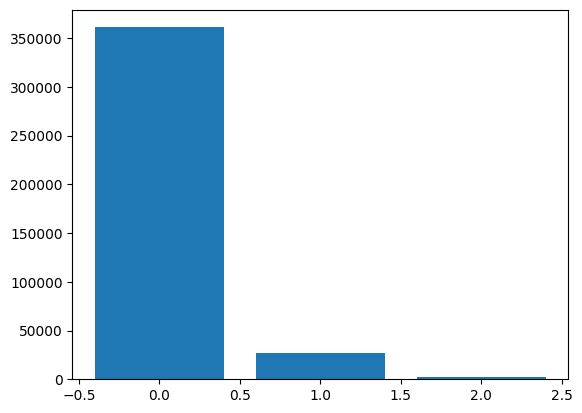

In [ ]:
### here we can see the extreme sparsity in relevance column
plt.bar(frequency_counts.index, frequency_counts.values)

In [ ]:
df.relevance.mean()

0.0781450186273528

In [ ]:
df['is_mobile'] = df['is_mobile'].astype('category')
df['destination_id'] = df['destination_id'].astype('category')
df['sort_type'] = df['sort_type'].astype('category')
df['search_day_of_week'] = df['search_day_of_week'].astype('category')
df['is_travel_ad'] = df['is_travel_ad'].astype('category')
df['is_free_cancellation'] = df['is_free_cancellation'].astype('category')
df['is_drr'] = df['is_drr'].astype('category')
df['point_of_sale'] = df['point_of_sale'].astype('category')
df['geo_location_country'] = df['geo_location_country'].astype('category')
df['review_count'] = df['review_count'].fillna(0)

df['star_rating'] = df['star_rating'].astype('category')
df['review_rating'] = df['review_rating'].astype('category')
df['price_bucket'] = df['price_bucket'].astype('category')
df['search_hour_of_day'] = df['search_hour_of_day'].astype('category')

df['checkin_day'] = df['checkin_day'].astype('category')
df['checkout_day'] = df['checkout_day'].astype('category')

#df['geo_location_country'] = df['geo_location_country'].astype('category')

#df['point_of_sale'] = df['point_of_sale'].astype('category')



amenities =  ['AirConditioning',
  'AirportTransfer',
  'Bar',
  'FreeAirportTransportation',
  'FreeBreakfast',
  'FreeParking',
  'FreeWiFi',
  'Gym',
  'HighSpeedInternet',
  'HotTub',
  'LaundryFacility',
  'Parking',
  'PetsAllowed',
  'PrivatePool',
  'SpaServices',
  'SwimmingPool',
  'WasherDryer',
  'WiFi']



# change type to category:
for amenity in amenities:
  df[amenity] = df[amenity].astype('category')

In [ ]:
## keep only integer/float columns for XGB

df_model = df.drop(labels = ["user_id",
                             "checkin_date", "checkout_date", "num_clicks",
                             "is_trans", "sort_type", "rank_noad", "prop_id",
                             "star_rating", "destination_id"],
                    axis=1)

# if i exclude the initial rank from the data - do i ignore the potential effect
#  on relevance (clicks) the initial ranking has on the relevance proxies?

df_model.head()

,search_id,point_of_sale,geo_location_country,is_mobile,adult_count,child_count,infant_count,room_count,length_of_stay,booking_window,...,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,relevance
0,0,2,1,0,2,0,0,1,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0,2,1,0,2,0,0,1,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0,2,1,0,2,0,0,1,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3,0,2,1,0,2,0,0,1,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0,2,1,0,2,0,0,1,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0


In [ ]:
categorical_features = df_model.select_dtypes(include=['category']).columns.tolist()
numeric_features = df_model.select_dtypes(exclude=['category']).columns.tolist()


categorical_features, numeric_features

(['point_of_sale',
  'geo_location_country',
  'is_mobile',
  'search_day_of_week',
  'search_hour_of_day',
  'checkin_day',
  'checkout_day',
  'is_travel_ad',
  'review_rating',
  'is_free_cancellation',
  'is_drr',
  'price_bucket',
  'AirConditioning',
  'AirportTransfer',
  'Bar',
  'FreeAirportTransportation',
  'FreeBreakfast',
  'FreeParking',
  'FreeWiFi',
  'Gym',
  'HighSpeedInternet',
  'HotTub',
  'LaundryFacility',
  'Parking',
  'PetsAllowed',
  'PrivatePool',
  'SpaServices',
  'SwimmingPool',
  'WasherDryer',
  'WiFi'],
 ['search_id',
  'adult_count',
  'child_count',
  'infant_count',
  'room_count',
  'length_of_stay',
  'booking_window',
  'rank',
  'review_count',
  'relevance'])

In [ ]:
# transfrom all categorical features into integer variables
for cat in categorical_features:
  df_model[cat] = df_model[cat].apply(lambda x: int(x))

In [ ]:
df_model.head()

,search_id,point_of_sale,geo_location_country,is_mobile,adult_count,child_count,infant_count,room_count,length_of_stay,booking_window,...,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,relevance
0,0,2,1,0,2,0,0,1,1.0,1.0,...,0,1,0,0,0,0,1,0,0,0
1,0,2,1,0,2,0,0,1,1.0,1.0,...,1,1,0,0,0,0,1,0,0,0
2,0,2,1,0,2,0,0,1,1.0,1.0,...,0,1,0,1,0,0,1,0,0,0
3,0,2,1,0,2,0,0,1,1.0,1.0,...,0,1,0,0,0,0,1,0,0,0
4,0,2,1,0,2,0,0,1,1.0,1.0,...,0,1,0,1,0,0,1,0,0,0


In [ ]:
# XGBoost needs categories to be integers starting from zero
# transfrom all categorical features into integer variables

In [ ]:
df_model.head()

,search_id,point_of_sale,geo_location_country,is_mobile,adult_count,child_count,infant_count,room_count,length_of_stay,booking_window,...,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,relevance
0,0,2,1,0,2,0,0,1,1.0,1.0,...,0,1,0,0,0,0,1,0,0,0
1,0,2,1,0,2,0,0,1,1.0,1.0,...,1,1,0,0,0,0,1,0,0,0
2,0,2,1,0,2,0,0,1,1.0,1.0,...,0,1,0,1,0,0,1,0,0,0
3,0,2,1,0,2,0,0,1,1.0,1.0,...,0,1,0,0,0,0,1,0,0,0
4,0,2,1,0,2,0,0,1,1.0,1.0,...,0,1,0,1,0,0,1,0,0,0


In [ ]:
df_model.shape

(389481, 40)

In [ ]:
# drop rows with NaN values
# there should be no more rows dropped
df_model = df_model.dropna()

df_model.shape

(389481, 40)

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

def split_by_qid(df, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df['search_id'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df[df['search_id'].isin(ids[train_idx])], df[df['search_id'].isin(ids[test_idx])]

#_, temp_df = split_by_qid(df2, test_size=0.2)
train_df, test_df = split_by_qid(df_model, test_size=0.3)

train_df.shape, test_df.shape

((272842, 40), (116639, 40))

In [ ]:
from sklearn.preprocessing import normalize, StandardScaler, OneHotEncoder

# data needs to be ordered by qid for XGBRank function
train_df = train_df.sort_values(by = "search_id")
X_train = train_df.drop(columns = ["search_id", "relevance"])


# feature names for plots later on
#features_list = X.columns.tolist()

# scale features
#X = normalize(X)

# relevance label is outcome var
y_train = train_df["relevance"]
qid_train = train_df["search_id"]

In [ ]:
X_train[0:5]

,point_of_sale,geo_location_country,is_mobile,adult_count,child_count,infant_count,room_count,length_of_stay,booking_window,search_day_of_week,...,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi
30,1,1,0,2,0,0,1,5.0,26.0,3,...,1,0,1,0,0,0,0,0,0,0
58,1,1,0,2,0,0,1,5.0,26.0,3,...,0,0,0,1,1,0,0,0,0,1
57,1,1,0,2,0,0,1,5.0,26.0,3,...,1,1,1,1,1,0,1,1,0,0
56,1,1,0,2,0,0,1,5.0,26.0,3,...,0,0,1,1,0,0,0,0,0,0
55,1,1,0,2,0,0,1,5.0,26.0,3,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
# same data format for test data
test_df = test_df.sort_values(by = "search_id")

X_test = test_df.drop(columns = ["search_id", "relevance"])

#X_test = normalize(X_test)

y_test = test_df["relevance"]
qid_test = test_df["search_id"]

In [ ]:
categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['category']).columns.tolist()


categorical_features, numeric_features

(['point_of_sale',
  'geo_location_country',
  'is_mobile',
  'search_day_of_week',
  'search_hour_of_day',
  'checkin_day',
  'checkout_day',
  'is_travel_ad',
  'review_rating',
  'is_free_cancellation',
  'is_drr',
  'price_bucket',
  'AirConditioning',
  'AirportTransfer',
  'Bar',
  'FreeAirportTransportation',
  'FreeBreakfast',
  'FreeParking',
  'FreeWiFi',
  'Gym',
  'HighSpeedInternet',
  'HotTub',
  'LaundryFacility',
  'Parking',
  'PetsAllowed',
  'PrivatePool',
  'SpaServices',
  'SwimmingPool',
  'WasherDryer',
  'WiFi'],
 ['adult_count',
  'child_count',
  'infant_count',
  'room_count',
  'length_of_stay',
  'booking_window',
  'rank',
  'review_count'])

In [ ]:
# scale numerical

scaler=StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [ ]:
# create dummies for categorical --> is now done in XGBoost

#X_train = pd.get_dummies(X_train, columns=categorical_features)
#X_test = pd.get_dummies(X_test, columns=categorical_features)

In [ ]:
X_train.head()

,point_of_sale,geo_location_country,is_mobile,adult_count,child_count,infant_count,room_count,length_of_stay,booking_window,search_day_of_week,...,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi
31,1,1,0,-0.17665,-0.34638,-0.010131,-0.01602,0.73371,-0.207281,3,...,1,0,1,1,0,0,0,1,0,0
30,1,1,0,-0.17665,-0.34638,-0.010131,-0.01602,0.73371,-0.207281,3,...,1,0,1,0,0,0,0,0,0,0
56,1,1,0,-0.17665,-0.34638,-0.010131,-0.01602,0.73371,-0.207281,3,...,0,0,1,1,0,0,0,0,0,0
32,1,1,0,-0.17665,-0.34638,-0.010131,-0.01602,0.73371,-0.207281,3,...,1,0,1,1,1,0,0,1,0,1
57,1,1,0,-0.17665,-0.34638,-0.010131,-0.01602,0.73371,-0.207281,3,...,1,1,1,1,1,0,1,1,0,0


### Scaling of numerical variables

In [ ]:
#len(group_train)

In [ ]:
import xgboost as xgb

In [ ]:
# use the examplary code from xgboost documentation as a starting point:
# https://xgboost.readthedocs.io/en/stable/python/examples/learning_to_rank.html#sphx-glr-python-examples-learning-to-rank-py
# specifically for click data

ranker = xgb.XGBRanker(
        n_estimators=512,
        tree_method="hist",
        device="cuda",
        learning_rate=0.01,
        reg_lambda=1.5,
        subsample=0.8,
        sampling_method="gradient_based",
        # to handle categorical features with many features
        enable_categorical=True,
        # above 7 categories no one hot encoding
        max_cat_to_onehot = 7,
        max_cat_threshold = 15,
        # LTR specific parameters
        objective="rank:ndcg",
        # - Enable bias estimation
        lambdarank_unbiased=True,
        # - normalization (1 / (norm + 1))
        lambdarank_bias_norm=1,
        # - Focus on the top 12 documents
        lambdarank_num_pair_per_sample=12,
        lambdarank_pair_method="topk",
        ndcg_exp_gain=True,
        eval_metric=["ndcg@1", "ndcg@3", "ndcg@5", "ndcg@10", "ndcg@50"],
        lambdarank_normalization = False
 )

In [ ]:
# ranker = xgb.XGBRanker(
#        n_estimators=1000,
#        learning_rate=0.1,
#        objective='rank:pairwise', # this is RankNet loss or the pairwise logistic loss
#        lambdarank_num_pair_per_sample=25,
#        lambdarank_pair_method="topk",
#        reg_lambda=0.05,
#        # verbose = True,
#        tree_method = 'hist',
#        eval_metric = 'ndcg',
#        eta = 0.3
#    )



In [ ]:
# fit on training data

ranker.fit(
    X_train,
    y_train,
    qid=qid_train,
    eval_set=[(X_test, y_test)],
    eval_qid=[qid_test],
    verbose = True
)

[0]	validation_0-ndcg@1:0.46653	validation_0-ndcg@3:0.51230	validation_0-ndcg@5:0.55159	validation_0-ndcg@10:0.60785	validation_0-ndcg@50:0.66782
[1]	validation_0-ndcg@1:0.46466	validation_0-ndcg@3:0.51467	validation_0-ndcg@5:0.55456	validation_0-ndcg@10:0.61062	validation_0-ndcg@50:0.66912
[2]	validation_0-ndcg@1:0.46819	validation_0-ndcg@3:0.51588	validation_0-ndcg@5:0.55516	validation_0-ndcg@10:0.61113	validation_0-ndcg@50:0.67006
[3]	validation_0-ndcg@1:0.46826	validation_0-ndcg@3:0.51590	validation_0-ndcg@5:0.55514	validation_0-ndcg@10:0.61028	validation_0-ndcg@50:0.66990
[4]	validation_0-ndcg@1:0.47102	validation_0-ndcg@3:0.51772	validation_0-ndcg@5:0.55648	validation_0-ndcg@10:0.61187	validation_0-ndcg@50:0.67126
[5]	validation_0-ndcg@1:0.47185	validation_0-ndcg@3:0.51825	validation_0-ndcg@5:0.55714	validation_0-ndcg@10:0.61297	validation_0-ndcg@50:0.67195
[6]	validation_0-ndcg@1:0.47206	validation_0-ndcg@3:0.51795	validation_0-ndcg@5:0.55724	validation_0-ndcg@10:0.61330	validat

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:33:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambdarank_normalization" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-ndcg@1:0.47060	validation_0-ndcg@3:0.51827	validation_0-ndcg@5:0.55680	validation_0-ndcg@10:0.61275	validation_0-ndcg@50:0.67169
[8]	validation_0-ndcg@1:0.47309	validation_0-ndcg@3:0.51927	validation_0-ndcg@5:0.55744	validation_0-ndcg@10:0.61393	validation_0-ndcg@50:0.67270
[9]	validation_0-ndcg@1:0.46936	validation_0-ndcg@3:0.51794	validation_0-ndcg@5:0.55589	validation_0-ndcg@10:0.61240	validation_0-ndcg@50:0.67130
[10]	validation_0-ndcg@1:0.46998	validation_0-ndcg@3:0.51859	validation_0-ndcg@5:0.55678	validation_0-ndcg@10:0.61292	validation_0-ndcg@50:0.67194
[11]	validation_0-ndcg@1:0.47019	validation_0-ndcg@3:0.51885	validation_0-ndcg@5:0.55698	validation_0-ndcg@10:0.61411	validation_0-ndcg@50:0.67232
[12]	validation_0-ndcg@1:0.46957	validation_0-ndcg@3:0.51873	validation_0-ndcg@5:0.55707	validation_0-ndcg@10:0.61408	validation_0-ndcg@50:0.67223
[13]	validation_0-ndcg@1:0.46874	validation_0-ndcg@3:0.51809	validation_0-ndcg@5:0.55643	validation_0-ndcg@10:0.61411	val

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device='cuda',
          early_stopping_rounds=None, enable_categorical=True,
          eval_metric=['ndcg@1', 'ndcg@3', 'ndcg@5', 'ndcg@10', 'ndcg@50'],
          feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          lambdarank_bias_norm=1, lambdarank_normalization=False,
          lambdarank_num_pair_per_sample=12, lambdarank_pair_method='topk',
          lambdarank_unbiased=True, learning_rate=0.01, max_bin=None,
          max_cat_threshold=15, max_cat_to_onehot=7, max_delta_step=None,
          max_depth=None, max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, ...)

In [ ]:
#ranker.evals_result_

In [ ]:
# from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
# Works with cv in scikit-learn, along with HPO utilities like GridSearchCV
# kfold = StratifiedGroupKFold(n_splits = 5, shuffle=False)

# what is the default scoring for XGBRanker -> is it eval_metric from the model above

# cross_val_score(ranker, X, y, cv=kfold, groups=X.qid)

Prediction: needs to be done by query in query_test

---

To do:
- calculate a scores by query, then calculate ndcg for each query
- how needs data to be stored/ordered/porvided?
- what is the scoring function used as default
- should it be replaced by NDCG?

In [ ]:
import numpy as np

def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

In [ ]:
# this yields the same result as ndcg@10 when I provide the eval set in the ranker.fit
# https://forecastegy.com/posts/xgboost-learning-to-rank-python/

# here I did not provide eval_set and calculated the NDCG "by hand" with ranker.predict
qids = np.unique(qid_test)


ndcg_ = list()

for i, qid in enumerate(qids):
    y = y_test[qid_test == qid]

    if np.sum(y) == 0:
        continue

    p = ranker.predict(X_test[qid_test == qid])

    idcg = ndcg(y, y, k=10)
    ndcg_.append(ndcg(p, y, k=10) / idcg)

np.mean(ndcg_)
# 0.61987

# calculates scores over all queries
# scores = ranker.predict(X_test)

# y_test_df = pd.DataFrame({"relevance": y_test, "predicted_scores": scores, "qid": qid_test})

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:20:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.6203526222561074

In [ ]:
#### Sanity check: calculate NDCG for original ranks in data with the same function


In [ ]:
scores

[array([-0.12776974, -0.10155143, -1.4433403 ,  0.01247631, -1.2146368 ,
        -1.3815126 , -1.3595454 , -1.492801  , -1.2146368 , -1.4239556 ,
        -0.8072713 , -0.95652497, -0.7145431 , -0.6621037 , -0.42800474,
        -0.53528625, -1.3715534 , -1.162192  , -1.1003672 , -0.91592634,
        -1.0145565 , -0.65238506, -1.5067526 , -1.3795944 , -1.2045407 ,
        -1.1016827 , -1.4355603 , -0.870169  , -0.00751886, -0.20010796],
       dtype=float32),
 array([-1.2003037 , -0.88808465,  2.4347594 ,  0.42109108, -0.9816218 ,
        -1.5700532 ,  0.07464378, -0.09950983, -0.03911042, -0.72207487,
        -0.29348606, -1.6975707 , -1.4406093 , -0.50448036, -0.5914832 ,
        -0.5579216 , -1.0642626 , -0.90422565, -0.9198835 , -0.8751856 ,
        -1.395642  , -0.97945166, -1.5797315 , -1.2775787 , -1.3919865 ,
        -1.3346611 , -1.5077481 , -1.5947634 , -1.5426228 , -1.639801  ],
       dtype=float32),
 array([-0.23972008, -0.39546898, -0.29070583, -0.3591385 , -0.33576754,
   

In [ ]:
## add qid to score

In [ ]:
y_test_df.head()

,relevance,predicted_scores,qid
0,0,-0.127770,0
1,0,-0.101551,0
29,0,-1.443340,0
2,0,0.012476,0
27,0,-1.214637,0


In [ ]:
import numpy as np
from sklearn.metrics import ndcg_score

# throw out rows where qid is unique - for those ndcg is not possible to calculate
# Find counts of each group
group_counts = y_test_df['qid'].value_counts()
unique_groups = group_counts[group_counts == 1].index
filtered_df = y_test_df[~y_test_df['qid'].isin(unique_groups)]


In [ ]:
ndcg_per_query = []
for group_name, group_df in filtered_df.groupby('qid'):
    pred_scores = group_df['predicted_scores']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score(y_true = [true_labels], y_score = [pred_scores])
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account all values of the ranking 0.4200667243489329


In [ ]:
ndcg_per_query = []
for group_name, group_df in filtered_df.groupby('qid'):
    pred_scores = group_df['predicted_scores']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account the first 20 values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account the first 20 values of the ranking 0.36550008903988135


In [ ]:
ndcg_per_query = []
for group_name, group_df in filtered_df.groupby('qid'):
    pred_scores = group_df['predicted_scores']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=10)
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account the first 10 values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account the first 10 values of the ranking 0.28742480435477974


In [ ]:
ndcg_per_query = []
for group_name, group_df in filtered_df.groupby('qid'):
    pred_scores = group_df['predicted_scores']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=5)
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account the first 5 values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account the first 5 values of the ranking 0.22098264211090526


In [ ]:
ndcg_per_query = []
for group_name, group_df in filtered_df.groupby('qid'):
    pred_scores = group_df['predicted_scores']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=1)
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account the first 1 values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account the first 1 values of the ranking 0.12331606217616581


(116639, 3)

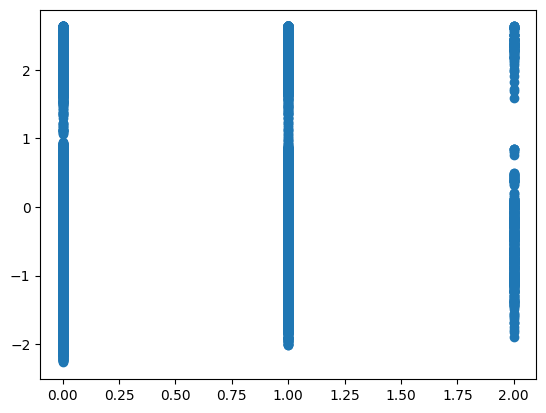

In [ ]:
### scatter plot of relevance and score
# we expect a higher predicted ranking vor values 1 and 2 on x - axis
plt.scatter(y_test_df["relevance"], y_test_df["predicted_scores"])

y_test_df.shape # can this plot be made for a specific search

In [ ]:
# calculate average predicted score by group

y_test_df.groupby(by = "relevance").mean()

,predicted_scores,qid
relevance,,
0,-0.871054,48851.244544
1,0.195701,48668.238597
2,-0.001299,51242.193825


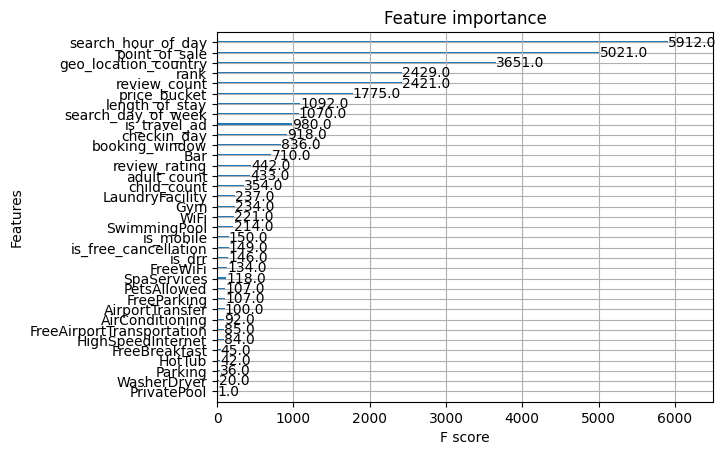

In [ ]:
#### show feature importance
from xgboost import plot_importance
# from matplotlib import pyplot

plot_importance(ranker)
plt.show()

# include label names


In [ ]:
# list of features
features_list = df_model.columns.tolist()

print(features_list)

['search_id', 'point_of_sale', 'geo_location_country', 'is_mobile', 'adult_count', 'child_count', 'infant_count', 'room_count', 'length_of_stay', 'booking_window', 'search_day_of_week', 'search_hour_of_day', 'checkin_day', 'checkout_day', 'rank', 'is_travel_ad', 'review_rating', 'review_count', 'is_free_cancellation', 'is_drr', 'price_bucket', 'AirConditioning', 'AirportTransfer', 'Bar', 'FreeAirportTransportation', 'FreeBreakfast', 'FreeParking', 'FreeWiFi', 'Gym', 'HighSpeedInternet', 'HotTub', 'LaundryFacility', 'Parking', 'PetsAllowed', 'PrivatePool', 'SpaServices', 'SwimmingPool', 'WasherDryer', 'WiFi', 'relevance']


Possible next steps:
- build it as a proper pipeline (similar to supervised classification)
- feature preprocessing (start with normalization) -> is it done correctly?
- include more features
- compare to initial ranks
- parameter that handles initial position bias
- separate models: only clicks and only transactions in relevance label
- position debiasing